# Notebook for anlaysing the structure of the social network.

This uses data from simulation batches run using release v1.0 of the model.

In [65]:
DATA_DIR = '../simulation_io/project_per_step_1_230521_v1.0/'
TS = 30

In [66]:
import pickle
import numpy as np
import pandas as pd
import networkx as nx
from scipy.stats import linregress
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline

import os, sys
MODEL_DIR = os.path.realpath(os.path.dirname('../superscript_model'))
sys.path.append(os.path.normpath(MODEL_DIR))
from superscript_model import model

In [67]:
sim_type = 'Basin_w_flex'

with open(DATA_DIR + sim_type + '/network_timestep_%d.gpickle' % TS, 'rb') as ifile:
    G = nx.read_gpickle(ifile) 

With 2 projects per timetsep there is a strongly connected component and many isolated nodes:

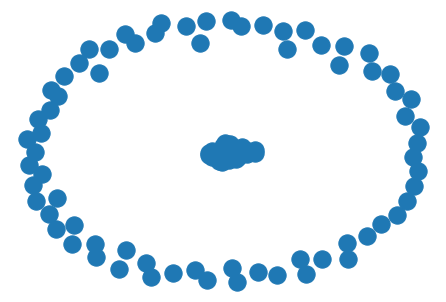

In [68]:
nx.draw(G)

In [69]:
S = [G.subgraph(c).copy() for c in nx.connected_components(G)]

There are many 'connected components' detected:

In [70]:
len(S)

71

But only one of these contains more than one node:

In [71]:
[len(si) for si in S if len(si) > 1]

[31]

This is the connected core of workers that have successfully collaborated on project:

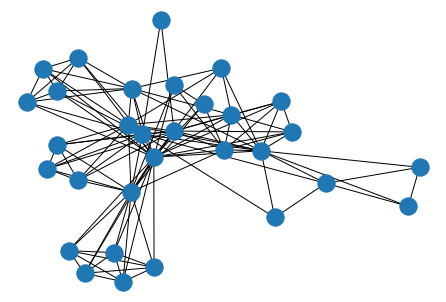

In [72]:
largest_cc = G.subgraph(max(nx.connected_components(G), key=len))
nx.draw(largest_cc)

In [73]:
edges = largest_cc.edges()
weights = [G[u][v]['weight'] for u,v in edges]

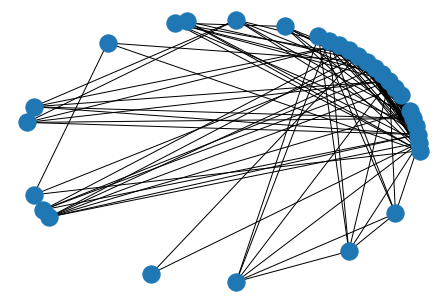

In [74]:
nx.draw(largest_cc, width=weights, pos=nx.circular_layout(G))

With 10 projects per timestep: